# Excercise GWAS

The goal of this excercise is to reproduce a published GWAS study.

We will be using the ["Mónica Meijón (2013). Genome-wide association study using cellular traits identifies a new regulator of root development in Arabidopsis. Nature Genetics"](https://www.nature.com/articles/ng.2824)

You can access the study and interactive Manhattan plots on [GWA-Portal](https://gwas.gmi.oeaw.ac.at/#/study/739/phenotypes). We also added the static Manhattan plots below generated by the [PyGWAS library](https://github.com/timeu/PyGWAS) (another GWAS library)

|   |   |
|---|---|
|![phenotype.png](images/meijon/phenotype.png)  | ![phenotype.png](images/meijon/paper.png)  |

First we initialize the inline plotting and disable some warnings


In [1]:
%matplotlib inline
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)
import pylab as pl

## Load the libraries

You will need to load the necessary libraries:
 - h5py
 - pandas
 - numpy
 - scipy

In [2]:
import h5py
import pandas as pd
import numpy as np
import scipy as sp

## Parse and convert phenotype data

First we need to parse the 2 phenotypes that are stored in *data/meijon/MC_length.csv* and *data/meijon/MZ_length.csv* into one panda dataframe and store the panda dataframe in *data/meijon/gwas.h5* using the panda hdf5 format

<div class="alert alert-warning">
You should merge the two datafarmes before saving them. Make sure to properly set the index and check the panda documentation how to merge 2 dataframes
</div>

In [3]:
# load MC_length.csv
mc_df = pd.read_csv('data/meijon/MC_length.csv',index_col="Accessionid")
mc_df.describe()

,MC_length
count,201.000000
mean,184.525483
std,32.549093
min,125.506000
25%,158.216000
50%,180.089000
75%,208.835000
max,271.742000


In [4]:
# load MZ_length.csv
mz_df = pd.read_csv('data/meijon/MZ_length.csv',index_col="Accessionid")
mz_df.describe()

,MZ_length
count,201.000000
mean,190.658154
std,31.569441
min,132.287000
25%,165.501000
50%,184.166000
75%,218.265000
max,265.750000


In [5]:
# merge both dataframes
pheno_df = pd.concat([mc_df,mz_df],axis=1)
pheno_df.describe()

,MC_length,MZ_length
count,201.000000,201.000000
mean,184.525483,190.658154
std,32.549093,31.569441
min,125.506000,132.287000
25%,158.216000,165.501000
50%,180.089000,184.166000
75%,208.835000,218.265000
max,271.742000,265.750000


In [6]:
# store merged panda dataframe into hdf5 file
pheno_df.to_hdf('data/meijon/gwas.h5',key='phenotype')

## Load and convert the genotype data 

Download the data from [here](https://drive.google.com/drive/folders/0BwYlrRGOfVARS01aMnFVVWotbXc), extract it and load the genotype data that is stored in an hdf5 file and create a Panda dataframe out if it. Then store the panda dataframe in *data/meijon/gwas.h5* using the panda hdf5 format

<div class="alert alert-warning">
The genotype is stored slightly differently inside this HDF5 compared to our previous notebooks. The chromosomes for example are not stored in an array but the chromosome regions (indices) are stored as an array in the attributes of the "positions" dataset. You need to generate the chromosome array using those indices.
Also don't subset the SNPs. Use all of them for the analysis below
</div>

<div class="alert alert-warning">
Store the chromosomes along with the positions as a Panda <a href="https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html#multiindex-advanced-indexing">Multiindex</a>. 
This will make it possible to filter by both indices (chromosome and position)
</div>

In [7]:
# load the genotype from the hdf5 file and create a dataframe that contains the SNP matrix. 
# The columns should be the sample_IDs and the index should be a MultiIndex of chromosomes and positions
folder = "/Users/uemit.seren/Downloads/regmap_SNP_MATRIX/"
with h5py.File('%s/all_chromosomes_binary.hdf5' % folder, 'r') as f:
    accessions = np.char.decode(f['accessions'][:]).astype(int)
    positions = f['positions'][:]
    chr_regions = f['positions'].attrs['chr_regions']
    chrs = f['positions'].attrs['chrs']
    snps = f['snps'][:]
    chromosomes = np.zeros(positions.shape)
    for ix,chr in enumerate(chrs):
        chr_region = chr_regions[ix]
        chromosomes[chr_region[0]:chr_region[1]] = chr
    geno_df = pd.DataFrame(snps, columns=accessions, 
                       index=[chromosomes,positions],
                       dtype='float64')
geno_df.info()

# Quiz:
# how much memory does the dataframe consume ? 
# are there ways to make it more efficient ? 

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 206088 entries, (1.0, 657) to (5.0, 26974904)
Columns: 1386 entries, 9381 to 9127
dtypes: float64(1386)
memory usage: 2.1 GB


<div class="alert alert-success">
When using the panda function to save to an hdf5 file, you can specify a 'key' under which the panda dataframe is stored inside the hdf5 file, allowing multiple different dataframes to be stored in the same hdf5 file
</div>

In [8]:
# store the genotype dataframe in the gwas.h5 dataset side by side with the phenotype
geno_df.to_hdf('data/meijon/gwas.h5',key='genotype')

In [9]:
# use bash command to check the size of the gwas.h5 file on the filesystem
!ls -ltha data/meijon/gwas.h5
# Quiz:
# does the file system on disk match the size in memory ?

-rw-r--r--  1 uemit.seren  staff   4.3G Nov 20 09:50 data/meijon/gwas.h5


In [10]:
# use HDF5 command line tools to check the hierarchical structure of the gwas.h5 file
!h5ls -r data/meijon/gwas.h5

# Quiz:
# what do you notice in the structure ? 

/                        Group
/genotype                Group
/genotype/axis0          Dataset {1386}
/genotype/axis1_label0   Dataset {206088}
/genotype/axis1_label1   Dataset {206088}
/genotype/axis1_level0   Dataset {5}
/genotype/axis1_level1   Dataset {205494}
/genotype/block0_items   Dataset {1386}
/genotype/block0_values  Dataset {206088, 1386}
/phenotype               Group
/phenotype/axis0         Dataset {2}
/phenotype/axis1         Dataset {201}
/phenotype/block0_items  Dataset {2}
/phenotype/block0_values Dataset {201, 2}


## Cleanup phenotypes and align genotype dataframe with phenotype dataframe

Remove N/A from the phenotype dataframe and make sure that the genotype and phenotype dataframes only contain accessions that occur in both

In [11]:
#Remove NaNs from the phenotype dataset
pheno_df.dropna(inplace=True)
pheno_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 7000 to 7418
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   MC_length  201 non-null    float64
 1   MZ_length  201 non-null    float64
dtypes: float64(2)
memory usage: 4.7 KB


In [12]:
#Filter the SNP matrix to only include the accessions for which we have genotypes
filtered_snps = geno_df[pheno_df.index]
filtered_snps

# Quiz
# have all accessions that have been phenotyped also genotyped ?

7000    6897    6987    6988    6990    6898    6992    6994    \
1.0 657          0.0     0.0     0.0     0.0     1.0     1.0     0.0     0.0   
    3102         0.0     0.0     0.0     0.0     1.0     1.0     0.0     0.0   
    4648         0.0     0.0     0.0     0.0     1.0     1.0     0.0     0.0   
    4880         1.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
    5975         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...              ...     ...     ...     ...     ...     ...     ...     ...   
5.0 26973018     0.0     0.0     0.0     0.0     1.0     0.0     0.0     0.0   
    26973269     0.0     0.0     0.0     1.0     0.0     0.0     0.0     0.0   
    26973441     1.0     1.0     0.0     0.0     1.0     0.0     0.0     0.0   
    26973598     0.0     0.0     1.0     0.0     0.0     0.0     0.0     1.0   
    26974904     0.0     0.0     0.0     1.0     0.0     1.0     1.0     0.0   

              7014    8256    ...  7477    7404    6979    100000  2320    \
1.0 657          0.0     0.0  ...     0.0     1.0     0.0     0.0     0.0   
    3102         0.0     0.0  ...     0.0     1.0     0.0     1.0     0.0   
    4648         0.0     0.0  ...     0.0     1.0     0.0     0.0     0.0   
    4880         0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
    5975         0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
...              ...     ...  ...     ...     ...     ...     ...     ...   
5.0 26973018     0.0     0.0  ...     0.0     0.0     0.0     1.0     0.0   
    26973269     0.0     1.0  ...     0.0     0.0     0.0     0.0     0.0   
    26973441     0.0     0.0  ...     0.0     1.0     0.0     1.0     0.0   
    26973598     0.0     0.0  ...     1.0     1.0     0.0     0.0     0.0   
    26974904     1.0     0.0  ...     0.0     1.0     1.0     0.0     1.0   

              6980    6982    6984    6985    7418    
1.0 657          0.0     1.0     0.0     0.0     0.0  
    3102         0.0     1.0     0.0     0.0     0.0  
    4648         0.0     1.0     0.0     0.0     0.0  
    4880         0.0     0.0     0.0     0.0     0.0  
    5975         0.0     0.0     0.0     0.0     0.0  
...              ...     ...     ...     ...     ...  
5.0 26973018     0.0     0.0     0.0     0.0     0.0  
    26973269     0.0     0.0     0.0     1.0     0.0  
    26973441     0.0     0.0     0.0     0.0     0.0  
    26973598     0.0     0.0     0.0     1.0     0.0  
    26974904     0.0     0.0     1.0     1.0     0.0  

[206088 rows x 201 columns]

## Check model assumption. 

Next we will check the distrubtion of the two phenotypes and perform the Shapiro-Wilk test for normality. 

<div class="alert alert-success">
To calculate the Shapiro-Wilk statistics, you can use the scipy.stats package.
</div>

/Users/uemit.seren/miniconda3/envs/gwas-lecture/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<Figure size 216x216 with 0 Axes>

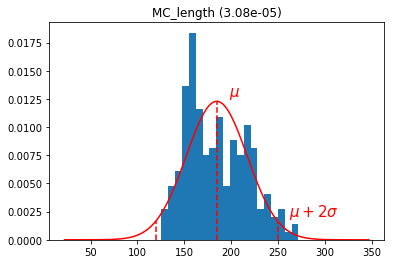

<Figure size 216x216 with 0 Axes>

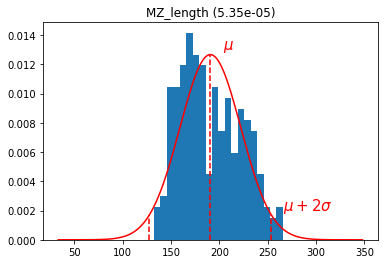

In [13]:
# Use limix to plot the phenotypic distrubition of the phenotype and add the Shapiro-Wilk pvalue to the title of the plot
# Don't forget to import the plot function from the limix library.

import limix.plot as lmx_plt
for ip, p_ID in enumerate(pheno_df.columns.values):
    phen_vals = pheno_df[p_ID].values
    pl.figure(figsize=[3,3])#create the figure
    shapiro_pval = sp.stats.shapiro(phen_vals)
    
    lmx_plt.plot_normal(phen_vals)
    pl.title("%s (%s)" % (p_ID,np.format_float_scientific(shapiro_pval.pvalue,precision=2)))

# Quiz:
# which phenotype is more normal ?
    

## Transformation of the phenotype

Perfom box-cox and log normal transformation, plot the histogram and calculcate the shapiro wilk score

For the log-normal transformation you can use following formular: 

$$
Y_{i}=\log( Y_{i} - \min(Y) + 0.1 * var(Y)) 
$$

<Figure size 864x360 with 0 Axes>

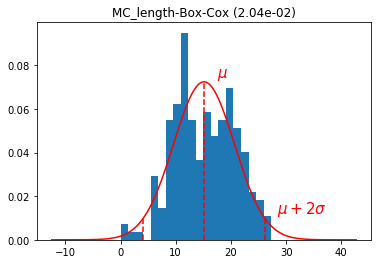

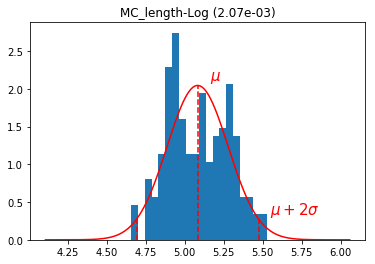

<Figure size 864x360 with 0 Axes>

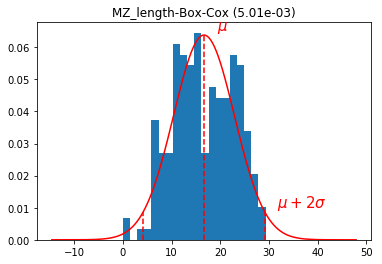

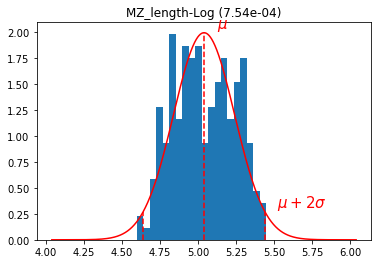

In [14]:
# Plot the histogram and calculate the Shapiro-Wilk pvalue for box-cox and log transformed phenotypes
import limix.util as lmx_util
phen_vals_boxcox,max_log = lmx_util.preprocess.boxcox(pheno_df.values)
phen_vals_log =  np.log((pheno_df.values - np.min(pheno_df.values,axis=0)) + 0.1 * np.var(pheno_df.values,axis=0))
for ip, p_ID in enumerate(pheno_df.columns.values):
    pl.figure(figsize=[12,5])#create the figure
    phen_vals = phen_vals_boxcox[:,ip]
    shapiro_pval = sp.stats.shapiro(phen_vals)
    lmx_plt.plot_normal(phen_vals)
    pl.title("%s-Box-Cox (%s)" % (p_ID,np.format_float_scientific(shapiro_pval.pvalue,precision=2)))
    
    phen_vals = phen_vals_log[:,ip]
    shapiro_pval = sp.stats.shapiro(phen_vals)
    lmx_plt.plot_normal(phen_vals)
    pl.title("%s-Log (%s)" % (p_ID,np.format_float_scientific(shapiro_pval.pvalue,precision=2)))

# Quiz:
# Does the boxcox transformation help ?

# Standard linear regression

Run the standard linear regression for all 3 phenotypes (raw, box-cox and log transformed) and genetate the Manhattan plots 

In [15]:
# Run the linear regression and create a dataframe of the pvalues
from limix.qtl import qtl_test_lm
lm = qtl_test_lm(snps=filtered_snps.T.values, pheno=pheno_df.values)
pv = lm.getPv() # get P values
beta = lm.getBetaSNP() # get effect sizes
beta_ste = lm.getBetaSNPste() # get standard errors
pvalues_lm = pd.DataFrame(pv.T, index=positions,
                          columns=pheno_df.columns)
pvalues_lm.describe()

/Users/uemit.seren/miniconda3/envs/gwas-lecture/lib/python3.6/site-packages/limix/qtl/lmm.py:267: RuntimeWarning: invalid value encountered in true_divide
  ste = beta / z


,MC_length,MZ_length
count,2.060880e+05,2.060880e+05
mean,4.769335e-01,4.713710e-01
std,2.932688e-01,2.944155e-01
min,2.125619e-07,6.486229e-08
25%,2.178453e-01,2.098744e-01
50%,4.669775e-01,4.583992e-01
75%,7.304934e-01,7.259152e-01
max,1.000000e+00,1.000000e+00


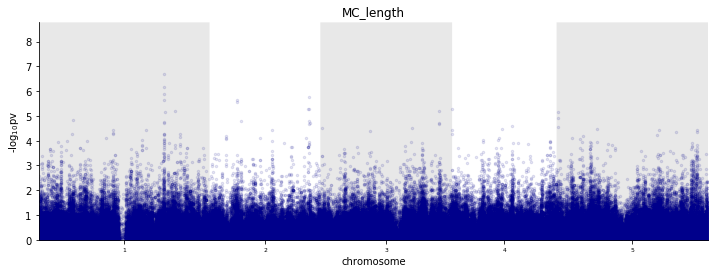

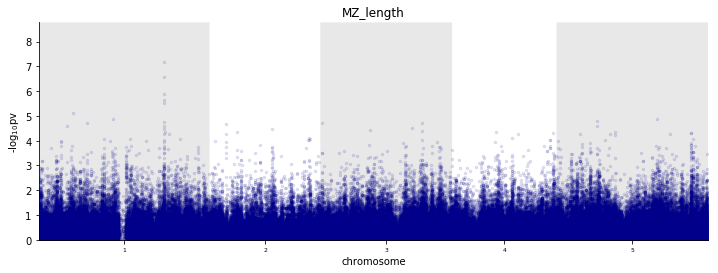

In [16]:
# Plot the manhattan plots for both phenotypes
for ip, p_ID in enumerate(pheno_df.columns):
    pl.figure(figsize=[12,4])
    lmx_plt.plot_manhattan(pd.DataFrame(dict(pv=pvalues_lm[p_ID].values,chrom=chromosomes,pos=positions)))
    pl.title(p_ID)

### Compare your plots to these:

#### MC length
![MC_length](images/meijon/MC_lm.png)

#### MZ length
![MC_length](images/meijon/MZ_lm.png)

## QQ-Plots
generate qq-plots and check the inflation

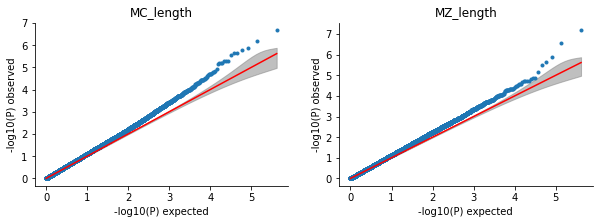

In [17]:
## plot the QQ plots for both phenotypes
pl.figure(figsize=[10,3])
for ip,p_ID in enumerate(pheno_df.columns):
    plt = pl.subplot(1,2,ip+1)
    lmx_plt.qqplot(pvalues_lm[p_ID].values)
    pl.title(p_ID)
    
# Quiz:
# can we see any inflation ?

### Compare your plots to these:

#### MC length
![MC_length](images/meijon/MC_qq_lm.png)

#### MZ length
![MC_length](images/meijon/MZ_qq_lm.png)

## Linear Mixel Model

Run the same analysis with the Linear Mixed Model

<div class="alert alert-warning">
Make sure to filter out monophormic SNPs from the genotype dataset before you calculate the kinship matrix and run the linear mixed model
</div>

In [18]:
# Filter out monomorphic SNP
# one way to do it is to sum up the SNPs (they are 0,1) and remove them if they are equal 0 or the number of accessions
# see the Numpy Lecture for how to use masks to filter arrays
monomorphic_snps = np.sum(filtered_snps.values.T,axis=0)
num_acc = filtered_snps.shape[0]
filter_idx = np.argwhere(~( (monomorphic_snps == 0) | (monomorphic_snps == num_acc)))
filtered_and_non_momoprhic = filtered_snps.values[filter_idx[:,0]]
# Quiz:
# how many SNP have been filtered out ?

In [19]:
# Estimate sample relatedness (kinship) using the monomorphic SNPs from above
from limix.stats import linear_kinship, gower_norm
sample_relatedness_unnormalized = linear_kinship(filtered_and_non_momoprhic.T)

100%|██████████| 100/100 [00:00<00:00, 310.73it/s]


In [20]:
#normalize it
sample_relatedness = gower_norm(sample_relatedness_unnormalized)

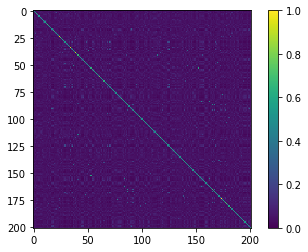

In [21]:
# Plot the kinship
from limix.plot import plot_kinship
plot_kinship(sample_relatedness)

# Quiz:
# Do you think it is possible to calculate the kinship for all accession once and use this even for a subset or 
# do you always have to re-calculate the kinship for the accessions that you are running the GWAS for ?

In [22]:
# Run linear mixed model
from limix.qtl import qtl_test_lmm
#set parameters for analysis
covs = None                 #covariates
searchDelta = False         #specify if delta should be optimized for each SNP
test="lrt"                  #specify type of statistical test

lmm = qtl_test_lmm(snps=filtered_and_non_momoprhic.T,
                   pheno=pheno_df.values,
                   K=sample_relatedness,
                   covs=covs,
                   test=test)

In [23]:
# Retrieve pvalues and create a dataframe for both phenotypes
# retrieve the P-values, the Betas, and the standard errors.
pv_lmm = lmm.getPv() # P values
beta_lmm = lmm.getBetaSNP() # effect sizes
beta_ste_lmm = lmm.getBetaSNPste() # standard errors

pvalues_lmm = pd.DataFrame(data=pv_lmm.T,
                           index=positions[filter_idx[:,0]],
                           columns=pheno_df.columns)
pvalues_lmm.describe()

,MC_length,MZ_length
count,2.060790e+05,2.060790e+05
mean,4.997518e-01,4.990662e-01
std,2.886204e-01,2.891957e-01
min,8.470512e-07,7.525402e-07
25%,2.504441e-01,2.481016e-01
50%,4.990417e-01,4.982614e-01
75%,7.487840e-01,7.500349e-01
max,9.999989e-01,9.999931e-01


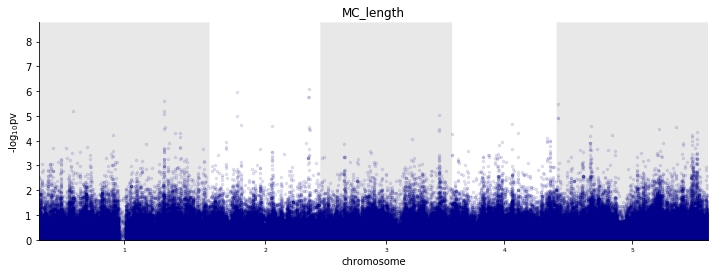

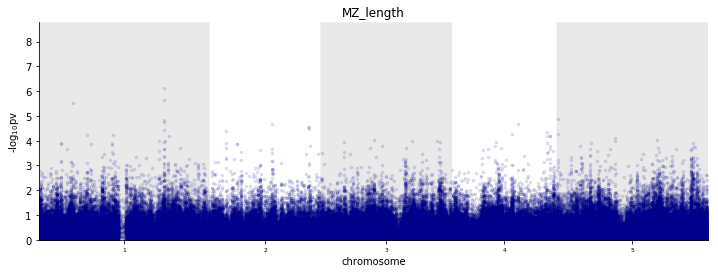

In [24]:
# Plot the manhattan plots for both phenotypes
for ip, p_ID in enumerate(pheno_df.columns):
    pl.figure(figsize=[12,4])
    lmx_plt.plot_manhattan(pd.DataFrame(dict(pv=pvalues_lmm[p_ID].values,chrom=chromosomes[filter_idx[:,0]],pos=pvalues_lmm.index)))
    pl.title(p_ID)


### Compare your plots to these:

#### MC length
![MC_length](images/meijon/MC_lmm.png)

#### MZ length
![MC_length](images/meijon/MZ_lmm.png)

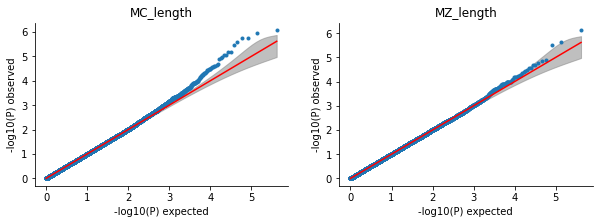

In [25]:
## plot the QQ plots for both phenotypes
pl.figure(figsize=[10,3])
for ip,p_ID in enumerate(pheno_df.columns):
    plt = pl.subplot(1,2,ip+1)
    lmx_plt.qqplot(pvalues_lmm[p_ID].values)
    pl.title(p_ID)
    
# Quiz:
# does the QQ plot improve compared to the LM ? 

### Compare your plots to these:

#### MC length
![MC_length](images/meijon/MC_qq_lmm.png)

#### MZ length
![MC_length](images/meijon/MZ_qq_lmm.png)